## Step 4: Analyze contents and give verdict on importance of reading

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from components.agents.curator_agent import curate_batch

from data import ContentManager
manager = ContentManager(base_path="../data")

INFO:data.content_manager:Loaded content index with 2633 entries


Get to_pursue items from df

In [34]:
df = pd.read_csv("../data/research_items.csv")

In [35]:
to_curate = df[
    (
        (df["scout_decision"] == "pursue") & 
        (df["content_loaded_locally"] == True) &
        (df["curated_at"].isna() if "curated_at" in df.columns else True)
    )
    | 
    (
        df["curator_summary"].str.startswith("ERROR")
    )
]

print(f"Curating {len(to_curate)} of {len(df)} items")

Curating 1 of 4355 items


Build items list with content

In [36]:
items = []
for _, row in to_curate.iterrows():
    content_info = manager.get(row["url"])
    if content_info and "content_path" in content_info:
        content = Path(content_info["content_path"]).read_text()
        items.append({
            "title": row["title"],
            "source": row["source"],
            "url": row["url"],
            "content": content,
        })
    else:
        print(f"No content for {row['url']}")

In [37]:
len(items) == len(to_curate)

True

Run curation

In [42]:
analyses = await curate_batch(items, batch_size=15)

INFO:components.agents.curator_agent:Processing batch 1/1 (1 items)
Curate batch 1/1:   0%|          | 0/1 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.anthropic.com/v1/messages?beta=true "HTTP/1.1 200 OK"
ERROR:components.agents.curator_agent:Curator error for 'MEEA: Mere Exposure Effect-Driven Confrontational ...': 1 validation error for CuratorAnalysis
  Invalid JSON: EOF while parsing a string at line 1 column 396 [type=json_invalid, input_value='{"summary": "MEEA (Mere ... MEEA constructs semant', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/json_invalid
Curate batch 1/1: 100%|██████████| 1/1 [00:42<00:00, 42.50s/it]


In [43]:
len(analyses)

1

In [44]:
len([analysis for analysis in analyses if analysis and analysis.summary.startswith("ERROR")])

1

Update df

In [29]:
url_to_analysis = {items[i]["url"]: analyses[i] for i in range(len(analyses))}

In [30]:
# Update each row
for url, analysis in url_to_analysis.items():
    mask = df["url"] == url
    
    # Skip if analysis is None
    if analysis is None:
        df.loc[mask, "curator_summary"] = "ERROR: Analysis failed"
        df.loc[mask, "curator_takeaways"] = ""
        df.loc[mask, "curator_tags"] = ""
        df.loc[mask, "applicability_score"] = 0
        df.loc[mask, "novelty_score"] = 0
        df.loc[mask, "priority_score"] = 0
        df.loc[mask, "verdict_reasoning"] = "ERROR: Analysis returned None"
        df.loc[mask, "curated_at"] = datetime.now().isoformat()
        continue
    
    df.loc[mask, "curator_summary"] = analysis.summary
    df.loc[mask, "curator_takeaways"] = "\n- ".join([""] + analysis.key_takeaways)  # list → bullet points
    df.loc[mask, "curator_tags"] = ", ".join(analysis.tags)  # list → comma-separated
    df.loc[mask, "applicability_score"] = analysis.applicability_score
    df.loc[mask, "novelty_score"] = analysis.novelty_score
    df.loc[mask, "priority_score"] = analysis.priority_score
    df.loc[mask, "verdict_reasoning"] = analysis.verdict_reasoning
    df.loc[mask, "curated_at"] = datetime.now().isoformat()

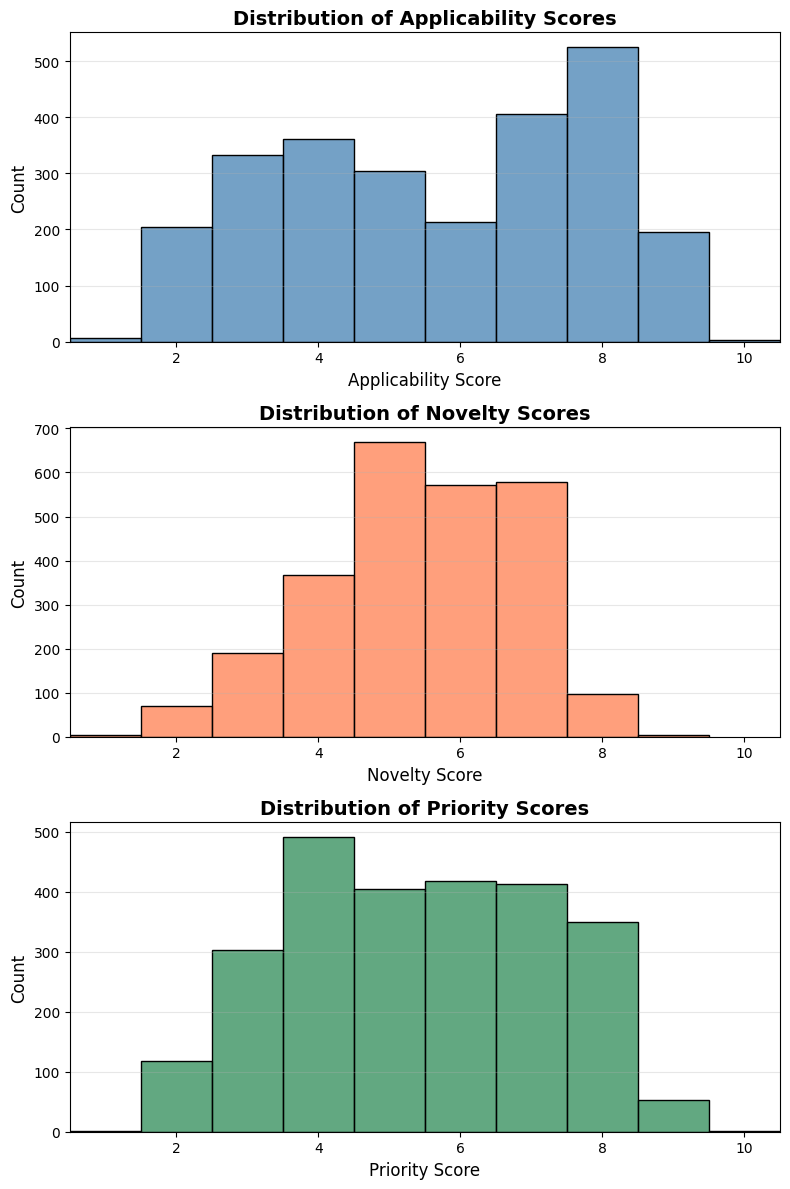

In [31]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# Applicability Score
sns.histplot(df['applicability_score'].dropna(), bins=range(1, 12), kde=False, ax=axes[0], color='steelblue', discrete=True)
axes[0].set_xlabel('Applicability Score', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Applicability Scores', fontsize=14, fontweight='bold')
axes[0].set_xlim(0.5, 10.5)
axes[0].grid(axis='y', alpha=0.3)

# Novelty Score
sns.histplot(df['novelty_score'].dropna(), bins=range(1, 12), kde=False, ax=axes[1], color='coral', discrete=True)
axes[1].set_xlabel('Novelty Score', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Distribution of Novelty Scores', fontsize=14, fontweight='bold')
axes[1].set_xlim(0.5, 10.5)
axes[1].grid(axis='y', alpha=0.3)

# Priority Score
sns.histplot(df['priority_score'].dropna(), bins=range(1, 12), kde=False, ax=axes[2], color='seagreen', discrete=True)
axes[2].set_xlabel('Priority Score', fontsize=12)
axes[2].set_ylabel('Count', fontsize=12)
axes[2].set_title('Distribution of Priority Scores', fontsize=14, fontweight='bold')
axes[2].set_xlim(0.5, 10.5)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [32]:
# Save
df.to_csv("../data/research_items.csv", index=False)
print(f"Updated {len(url_to_analysis)} items")

Updated 1 items


In [33]:
# Must reads (priority >= 8)
curated = df[df["curated_at"].notna()]
must_reads = curated[curated["priority_score"] >= 8].sort_values(by="priority_score", ascending=False)

print(f"\n🔥 Must reads: {len(must_reads)}")
print(must_reads[["title", "priority_score", "source"]].head(10))


🔥 Must reads: 404
                                                  title  priority_score  \
32    DeepSeek-R1: Incentivizing Reasoning Capabilit...            10.0   
3                                   Introducing GPT-5.2             9.0   
1532      PDF-Bench: Comprehensive PDF Parser Benchmark             9.0   
783   E2Rank: Your Text Embedding can Also be an Eff...             9.0   
780   Qwen3-Embedding (Embedding + Reranker series r...             9.0   
714                        modelcontextprotocol/servers             9.0   
713           modelcontextprotocol/modelcontextprotocol             9.0   
1907  Does It Tie Out? Towards Autonomous Legal Agen...             9.0   
600   Scaling Test-Time Compute Without Verification...             9.0   
442   FaithLens: Detecting and Explaining Faithfulne...             9.0   

               source  
32              arXiv  
3         OpenAI blog  
1532           GitHub  
783             arXiv  
780   GitHub (QwenLM)  
714        